## Simulation of  modified Stuart-Landau (MSL) model with (generalized) phase model

### Setup

In [1]:
using GeneralizedPhaseReduction
using DifferentialEquations, PyPlot
using PyCall
axes_grid1 = pyimport("mpl_toolkits.axes_grid1")

┌ Info: Precompiling GeneralizedPhaseReduction [10598a1f-f994-49a4-9c73-198b90050674]
└ @ Base loading.jl:1423
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



PyObject <module 'mpl_toolkits.axes_grid1' from 'C:\\ProgramData\\Miniconda3\\lib\\site-packages\\mpl_toolkits\\axes_grid1\\__init__.py'>

In [2]:
plt.rc("text", usetex=true)
PyCall.PyDict(plt."rcParams")["font.size"] = 14
PyCall.PyDict(plt."rcParams")["xtick.direction"] = "in"
PyCall.PyDict(plt."rcParams")["ytick.direction"] = "in"
PyCall.PyDict(plt."rcParams")["xtick.minor.visible"] = true
PyCall.PyDict(plt."rcParams")["ytick.minor.visible"] = true
PyCall.PyDict(plt."rcParams")["xtick.top"] = true 
PyCall.PyDict(plt."rcParams")["ytick.right"] = true 
PyCall.PyDict(plt."rcParams")["font.family"] = "Arial"
PyCall.PyDict(plt."rcParams")["text.latex.preamble"] = [raw"\usepackage{amsmath}"];

sys:1: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.


### Model definition

In [3]:
# Parameters and variables
c = 0.7; d = 0.8; eps = 0.08; # FHN parameters

# FHN vector field
dvdt(X, I) = X[1] - X[1]^3/3.0 - X[2] + I + 0.875
dudt(X) = eps * (X[1] + c - d * X[2])
F(X, I) = [dvdt(X, I), dudt(X)]

D, N = 2, 2 # number of dimensions, units
Nθ = 1000
G(X, K) = K * ([-1 1; 1 -1] * X[:, 1])
dt = 1e-3; T = 200.0; Nt = round(Int, T/dt)
alg = Vern9(); #Rosenbrock23() #Tsit5();

In [4]:
@time Ts, ω, Xs = find_stable_periodic_solution(F, 0, D, Nθ, [2, 0.5], dt, Tsit5(), 1, 0.0, print_progress=false)
println("Ts=", Ts, " (sec) , ω=", ω, " (Hz)")

  4.386911 seconds (27.59 M allocations: 1.395 GiB, 6.14% gc time, 89.28% compilation time)
Ts=36.419000000000004 (sec) , ω=0.1725249267464671 (Hz)


In [5]:
# F, Imin, Imax, dI, D, Nθ, nothing, dt, alg, origin_val_idx, origin_thr
ωI, ζθI, ξθI, XsI = generalized_phase_sensitivity_func(F, -0.55, 0.55, 0.01, D, Nθ, nothing, dt, Tsit5(), 1, 0.0);

[1/3] Computing Xs(θ, I) and Z(θ, I)...100%|████████████| Time: 0:01:09


[2/3] Computing ζ(θ, I)...
[3/3] Computing ξ(θ, I)...


In [6]:
function coupled_func!(dX, X, p, t)
    g, κ = p
    Iext = g(X) # input
    for i in 1:size(dX)[1]
        dX[i, :] = κ[i] * F(X[i, :], Iext[i])
    end
end

coupled_func! (generic function with 1 method)

If `K>0.10`, IΘ cannot be computed because it's outside the range of external forces that can produce a stable periodic orbit.

In [7]:
alg = Tsit5()
NΘ = 50
K = 0.10 
κ = [1.0, 1.5]
initθ = [0, π/2];
g(X) = G(X, K)

g (generic function with 1 method)

In [8]:
QΘ = compute_QΘ(g, N, D, XsI, κ, ωI, NΘ);

Computing P(θ₁, θ₂)...100%|█████████████████████████████| Time: 0:00:26


In [9]:
Θrange = range(0, 2π, length=100);
QΘmap = QΘ[1](Θrange, Θrange);

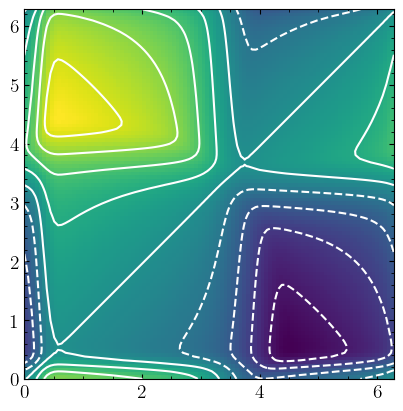

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\yamtak\.julia\packages\PyCall\3fwVL\src\numpy.jl:67


PyObject <matplotlib.image.AxesImage object at 0x00000000708DEF40>

In [10]:
contour(Θrange, Θrange, QΘmap, 10, colors="white")
imshow(reverse(QΘmap, dims=1), extent=(0, 2pi, 0, 2pi))

In [11]:
PΘmap = zeros(100, 100);

for k in 1:100
    for l in 1:100
        Θ = [Θrange[k], Θrange[l]]
        PΘmap[k, l] = g(hcat([[XsI[j](Θ[i], QΘmap[k, l]) for j in 1:D] for i in 1:N]...)')[1] - QΘmap[k, l]
    end
end; 

### Run simulation

In [12]:
Tos, Xos, _, _ = coupled_original_system(N, D, T, XsI, g, coupled_func!, initθ, κ, alg);
Tcpm, Xcpm, Θcpm = coupled_conventinal_phase_model(N, D, T, XsI, g, ωI, ζθI, initθ, κ, alg);

In [13]:
Tgpm, Xgpm, Θgpm = coupled_generalized_phase_model_PQ(N, D, T, XsI, QΘ, ωI, ζθI, ξθI, initθ, κ, g, alg);

In [14]:
Irange = -0.55:0.01:0.55; 

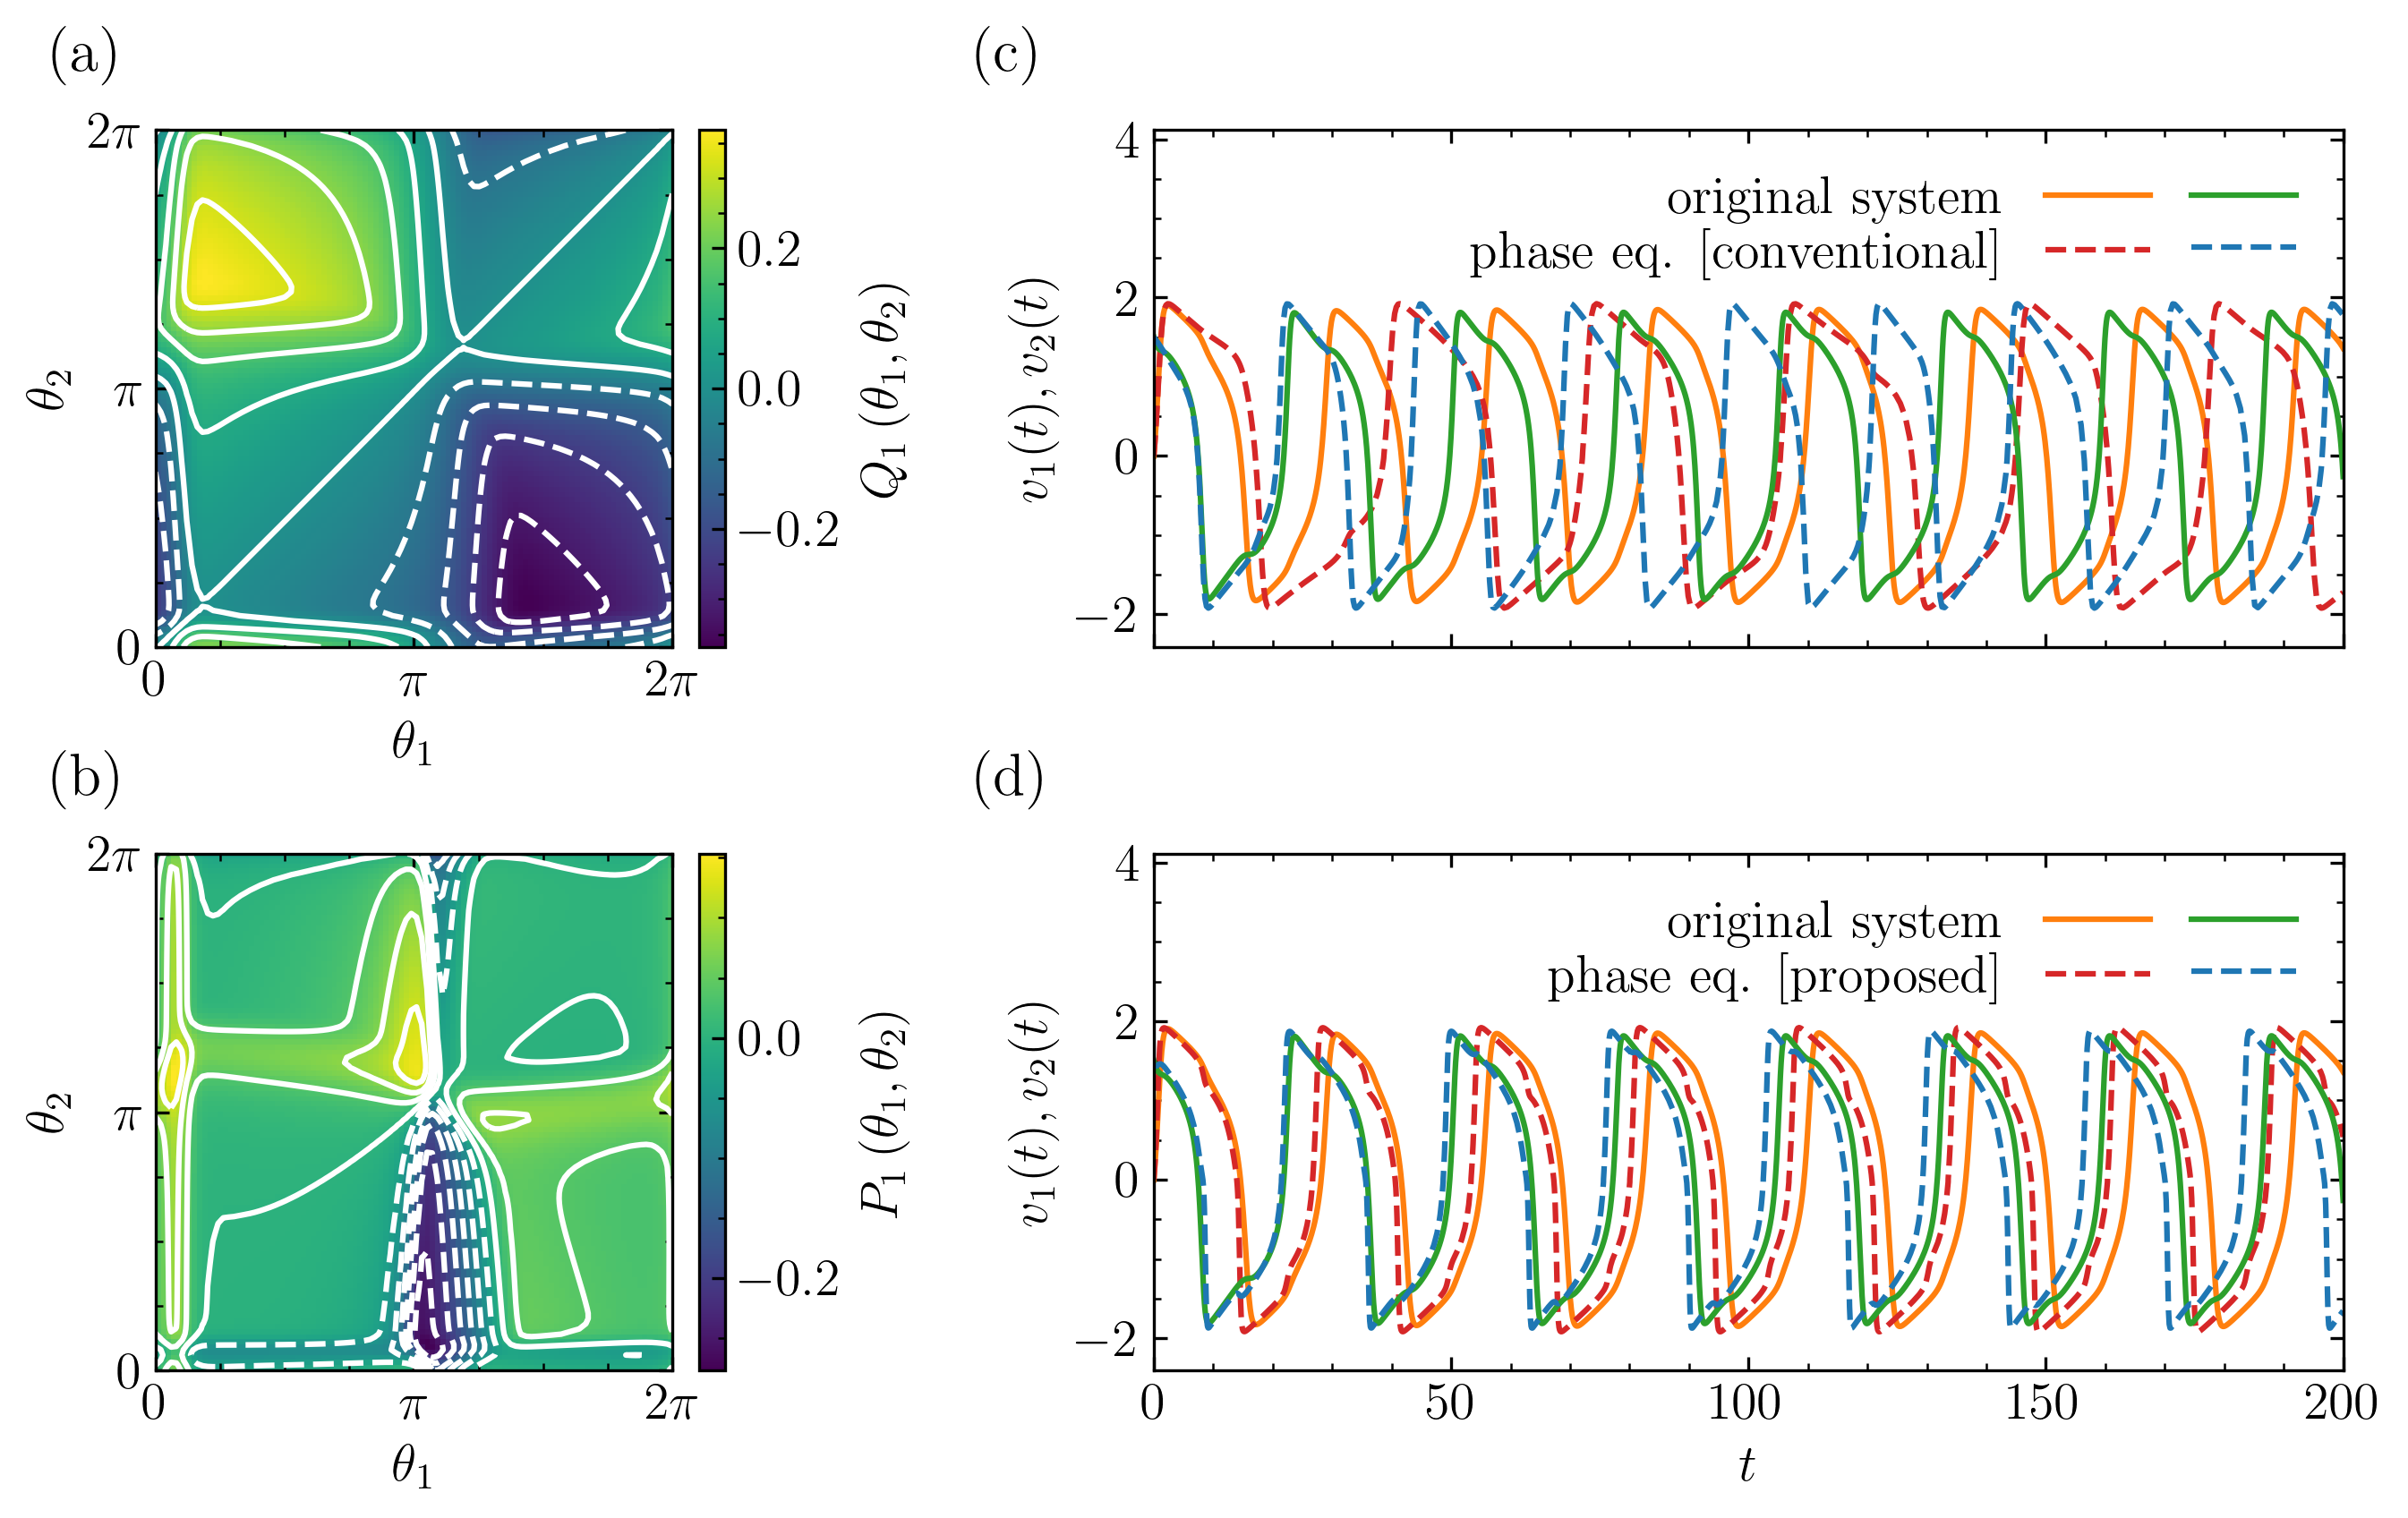

In [15]:
figure(figsize=(12, 6), dpi=300)
ax3 = subplot2grid((2, 2), (0, 0), rowspan=1, colspan=1)
contour(Θrange, Θrange, QΘmap, 10, colors="white")
imshow(reverse(QΘmap, dims=1), extent=(0, 2pi, 0, 2pi))
xlabel(L"$\theta_1$"); ylabel(L"$\theta_2$");
xticks([0, pi, 2pi], ["0", L"$\pi$", L"$2\pi$"]);
yticks([0, pi, 2pi], ["0", L"$\pi$", L"$2\pi$"]);
divider3 = axes_grid1.make_axes_locatable(ax3)
cax3 = divider3.append_axes("right", size="5%", pad=0.1)
cbar3 = colorbar(cax=cax3)#, ticks=[-0.5, 0, 0.5])
cbar3.set_label(L"$Q_1\left(\theta_1, \theta_2\right)$")
ax3.text(-0.2, 1.2, "(a)", fontsize=16, transform=ax3.transAxes, fontweight="bold", va="top")

ax4 = subplot2grid((2, 2), (1, 0), rowspan=1, colspan=1)
contour(Θrange, Θrange, PΘmap, 10, colors="white")
imshow(reverse(PΘmap, dims=1), extent=(0, 2pi, 0, 2pi))
xlabel(L"$\theta_1$"); ylabel(L"$\theta_2$");
xticks([0, pi, 2pi], ["0", L"$\pi$", L"$2\pi$"]);
yticks([0, pi, 2pi], ["0", L"$\pi$", L"$2\pi$"]);
divider4 = axes_grid1.make_axes_locatable(ax4)
cax4 = divider4.append_axes("right", size="5%", pad=0.1)
cbar4 = colorbar(cax=cax4)#, ticks=[-0.5, 0, 0.5])
cbar4.set_label(L"$P_1\left(\theta_1, \theta_2\right)$")
ax4.text(-0.2, 1.2, "(b)", fontsize=16, transform=ax4.transAxes, fontweight="bold", va="top")

ax1 = subplot2grid((2, 2), (0, 1), rowspan=1, colspan=1)
# title("Conventinal phase model")
plot(Tos, Xos[:, 1, 1], label="original system", color="tab:orange")
plot(Tcpm, Xcpm[:, 1, 1], "--", label="phase eq. [conventional]", color="tab:red")
plot(Tos, Xos[:, 2, 1], label=" ", color="tab:green")
plot(Tcpm, Xcpm[:, 2, 1], "--", label=" ", color="tab:blue")
xlim(0, T); ylim(ylim()[1]-0.3, ylim()[2]+2); ylabel(L"$v_1(t), v_2(t)$");
plt.gca().axes.xaxis.set_ticklabels([])
ax1.text(-0.15, 1.2, "(c)", fontsize=16, transform=ax1.transAxes, fontweight="bold", va="top")
legend(loc="upper right", ncol=2, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)

ax2 = subplot2grid((2, 2), (1, 1), rowspan=1, colspan=1)
plot(Tos, Xos[:, 1, 1], label="original system", color="tab:orange")
plot(Tgpm, Xgpm[:, 1, 1], "--", label="phase eq. [proposed]", color="tab:red")
plot(Tos, Xos[:, 2, 1], label=" ", color="tab:green")
plot(Tgpm, Xgpm[:, 2, 1], "--", label=" ", color="tab:blue")
xlim(0, T); ylim(ylim()[1]-0.3, ylim()[2]+2);  xlabel(L"$t$"); ylabel(L"$v_1(t), v_2(t)$"); 
ax2.text(-0.15, 1.2, "(d)", fontsize=16, transform=ax2.transAxes, fontweight="bold", va="top")
legend(loc="upper right", ncol=2, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)
subplots_adjust(hspace=0.4, wspace=0.1)
#show()
#tight_layout()
savefig("fig3.svg")